In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []
print("seed",seed)

print(datetime.datetime.now())

seed 3
2023-07-04 15:44:53.828067


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(0.0263)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-8.6376)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(25.9506)
train_loss:  -5.480271234339476
valid_loss:  -4.493439367103576
h_min_tilde -6.1621103 ell_tilde -5.282904860892296 kappa_tilde 0.001066485143231201
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -0.933836659926176
valid_loss:  -0.6855319692254066
weight_alpha 1.0 h_min_tilde -6.1621103 ell_tilde -0.8841757217860221 kappa_tilde 0.0004352792829544185


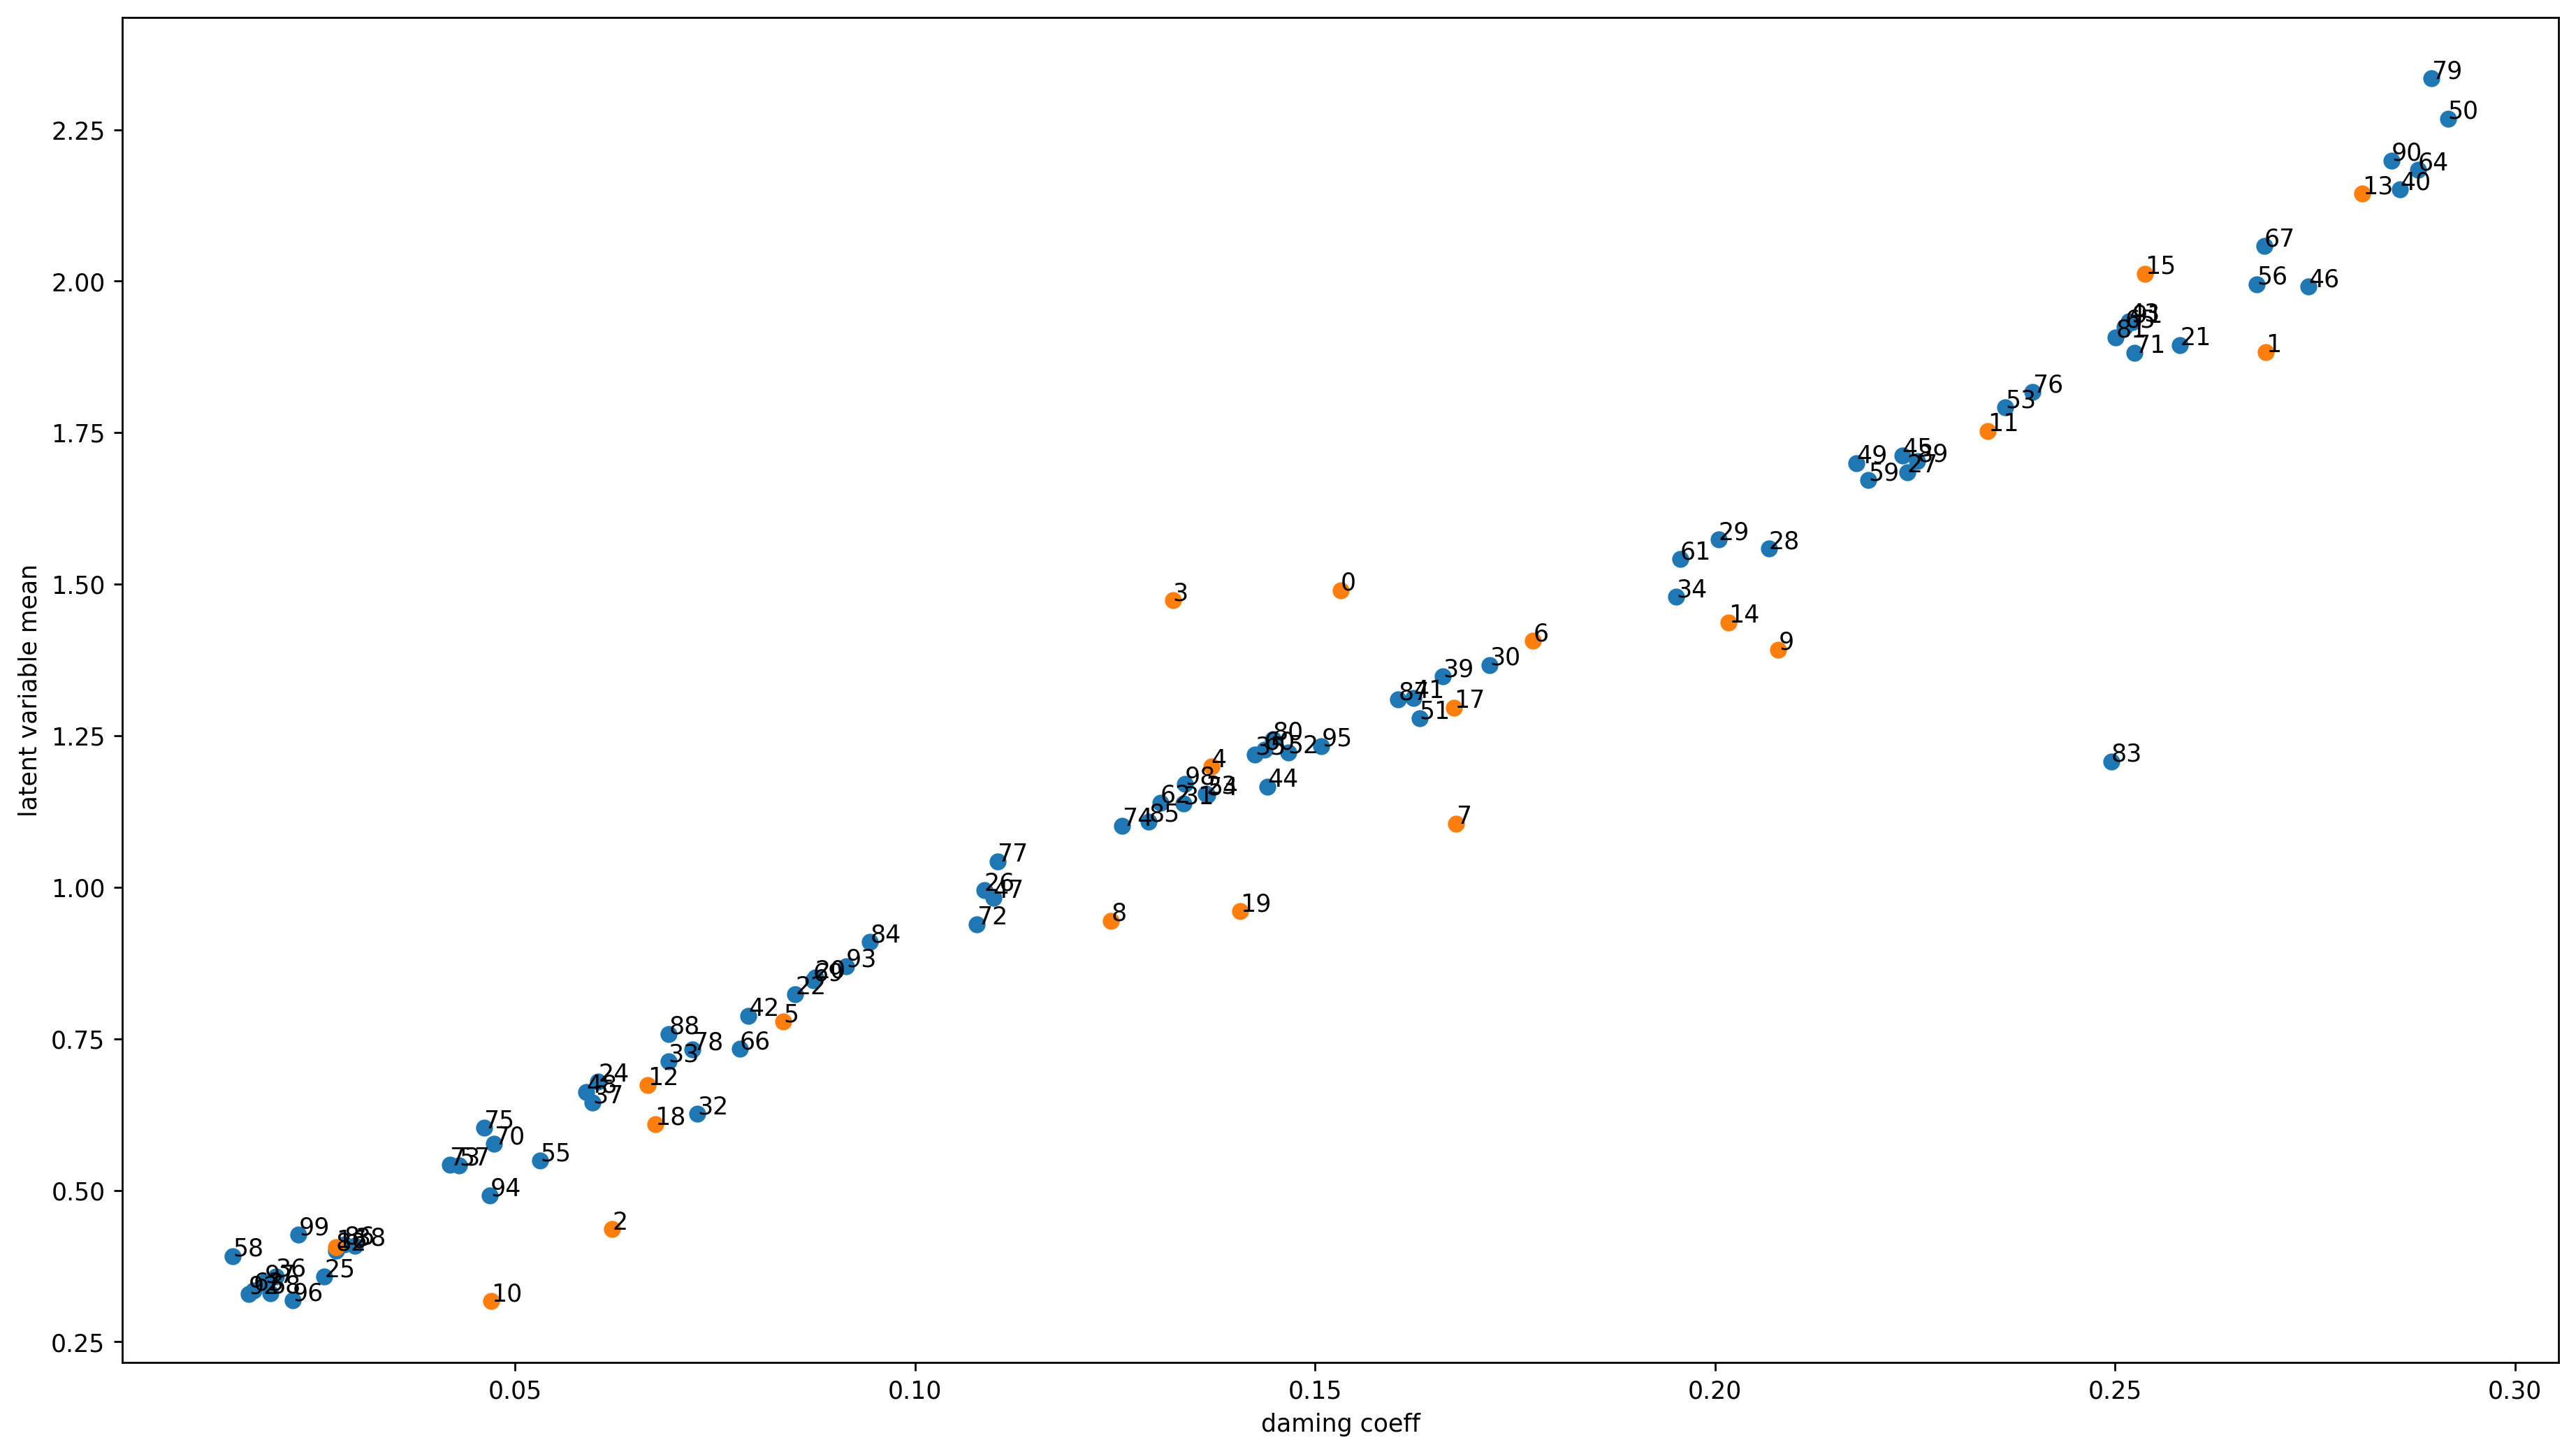

[0.15324828 0.26888793 0.06217286 0.13224295 0.13704997 0.08354618
 0.17725885 0.16765623 0.12453036 0.20794138]
[0.04706032 0.23409443 0.06658737 0.28091509 0.2017151  0.25372526
 0.0276651  0.16735223 0.06751635 0.14068207]
[0.08753783 0.25816017 0.08504636 0.13638662 0.06041361 0.02616881
 0.10865286 0.22402387 0.20675412 0.20044044]
[0.17183816 0.13354351 0.07280263 0.06917526 0.19514306 0.14252658
 0.02009083 0.05969281 0.0300313  0.16598332]
[0.28563037 0.1623059  0.079166   0.25175792 0.14407199 0.2234257
 0.27419258 0.10978218 0.05891417 0.21770089]
[0.29162951 0.1630783  0.14666197 0.23628546 0.13658381 0.05316401
 0.26771796 0.0429997  0.01473268 0.21921244]
[0.14369349 0.19566694 0.13065617 0.01731945 0.28791216 0.25123873
 0.07810352 0.2686711  0.01940196 0.08726173]
[0.0474101  0.25242589 0.10773226 0.04184014 0.12587483 0.04612206
 0.2396893  0.11031089 0.0721711  0.28956844]
[0.14474911 0.25010637 0.02763948 0.24952833 0.0943959  0.12924451
 0.02867004 0.16042046 0.06925

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.426039934158325

 2 3.425654411315918

 3 3.190120220184326

 4 3.1594483852386475

 5 3.1179211139678955

 6 3.19476056098938

 7 3.2284300327301025

 8 3.256138324737549

 9 3.106678009033203

 10 3.2350070476531982

 11 3.1939964294433594

 12 3.2641918659210205

 13 3.112840414047241

 14 3.4058210849761963

 15 3.211740493774414

 16 3.087935447692871

 17 3.3491122722625732

 18 3.130716562271118

 19 3.3361024856567383

 20 3.1562323570251465

 21 3.129162073135376

 22 3.1398699283599854

 23 3.075901746749878

 24 3.1269960403442383

 25 3.203657627105713

 26 3.1733646392822266

 27 3.0579380989074707

 28 3.174626588821411

 29 3.1357529163360596

 30 3.230517864227295

 31 3.028965473175049

 32 3.1423118114471436

 33 3.1845710277557373

 34 3.17441725730896

 35 3.207662582397461

 36 3.1693146228790283

 37 3.072763204574585

 38 3.139683961868286

 39 3.179408550262451

 40 3.2177960872650146

 41 3.366976499557495

 42 3.105266571044922

 43 3.2353577613830566

 

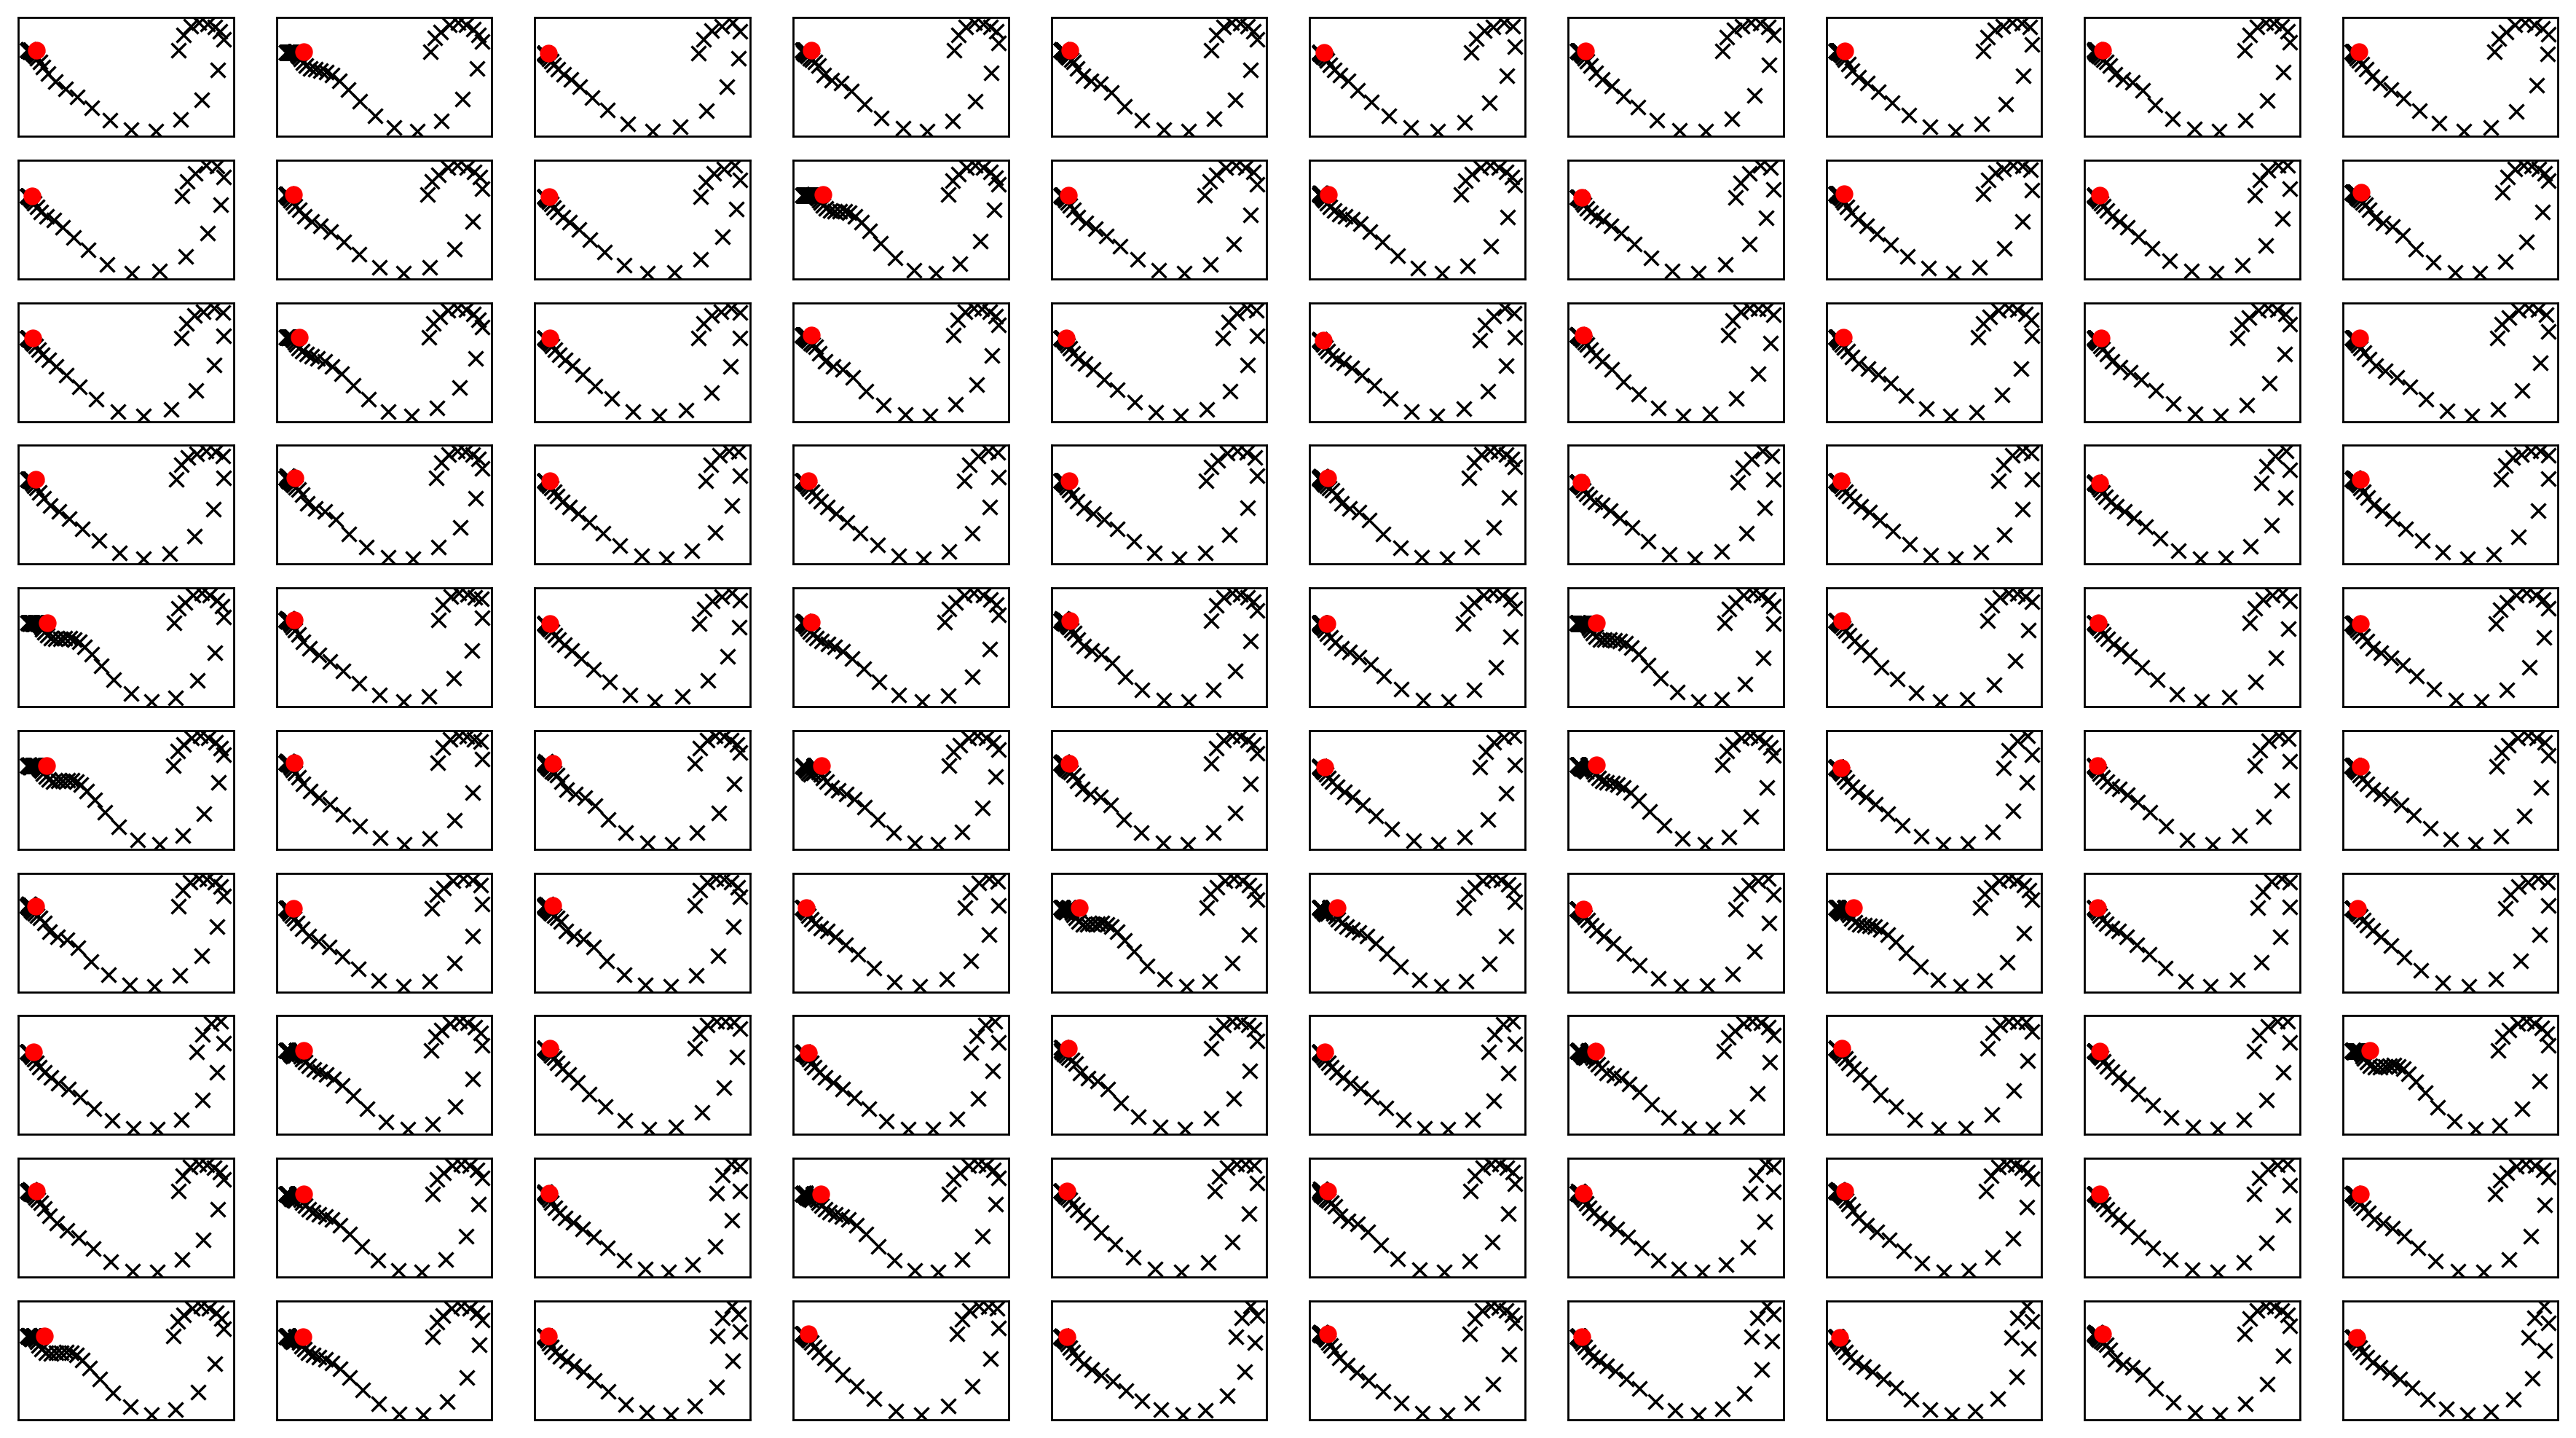

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 5.2653234004974365

 2 6.739065647125244

 3 4.128321886062622

 4 3.2623300552368164

 5 3.2399189472198486

 6 3.214294910430908

 7 3.2259626388549805

 8 3.1956570148468018

 9 3.246985912322998

 10 3.2178897857666016

 11 3.280036449432373

 12 3.250609874725342

 13 3.2352652549743652

 14 3.353546619415283

 15 3.2976527214050293

 16 3.1991710662841797

 17 3.160642623901367

 18 3.197216749191284

 19 3.2444560527801514

 20 3.375114917755127

 21 3.267098903656006

 22 3.2918572425842285

 23 3.333725929260254

 24 3.2653286457061768

 25 3.369617223739624

 26 3.3772857189178467

 27 3.221586227416992

 28 3.2943549156188965

 29 3.222087860107422

 30 3.270836591720581

 31 3.2721571922302246

 32 3.309547185897827

 33 3.236466646194458

 34 3.3290796279907227

 35 3.2361745834350586

 36 3.314203977584839

 37 3.2851810455322266

 38 3.202397108078003

 39 3.229854106903076

 40 3.247702121734619

 41 3.2819807529449463

 42 3.254729509353637

実環境方策rollout vs Sim環境方策rollout


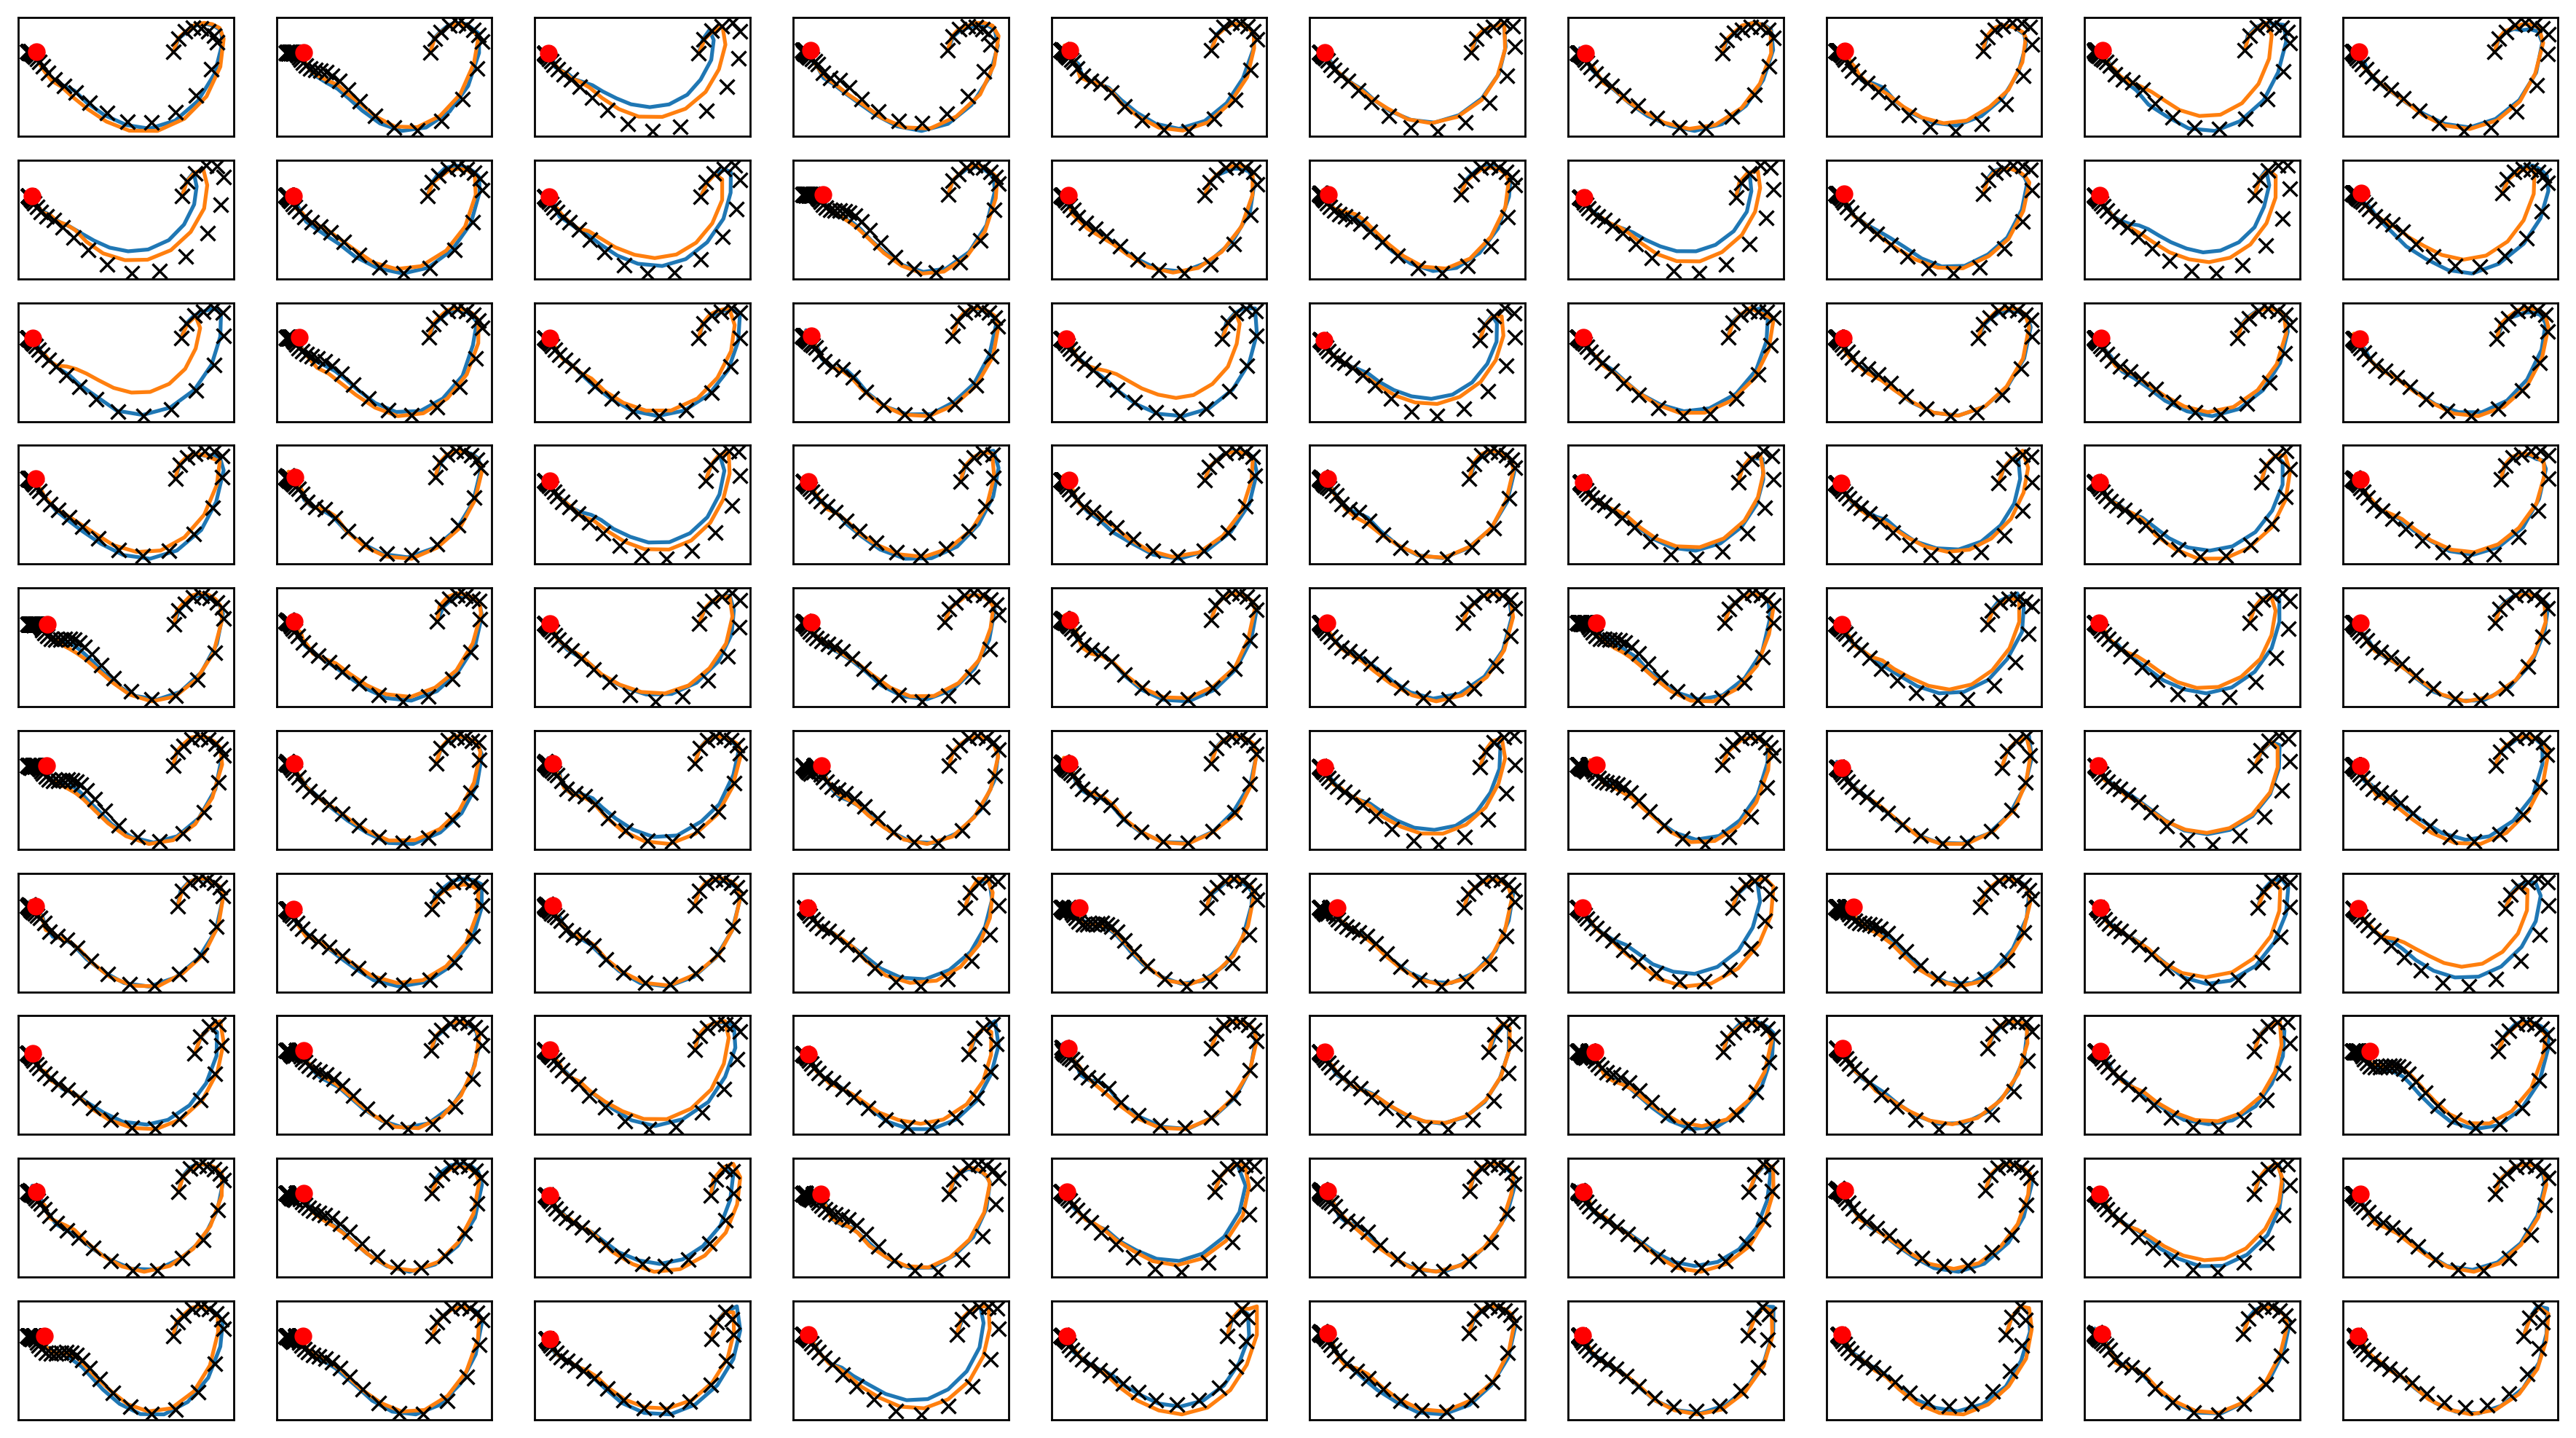

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-07-04 16:02:06.784344
